In [12]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [13]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/dart/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')
input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('dart test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp'
year      = [1958, 1961]
mon       = None
day       = None
record    = None 
box       = None
depth     = 100

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [14]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000
Dask client already running: <Client: 'tcp://127.0.0.1:43447' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: //proxy/42953/status,
Dashboard: //proxy/42953/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43447,Workers: 32
Dashboard: //proxy/42953/status,Total threads: 64
Started: 5 minutes ago,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:46441,Total threads: 2
Dashboard: //proxy/45919/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:35279,


In [15]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, _ , _ = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, None, None, n_cycl, do_allcycl)

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path != None): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
# #______________________________________________________________________________________________________    
# # concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
# input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# set predefined chunks size here! The optimized worker memory dependent chunk size is computed internally. 
# see def compute_optimal_chunks(path, client=None, varname=None, opti_dim='h', opti_chunkfrac=0.10):
# The here presetted values are used when tpv.load_data_fesom2( ..., opti_dim=None', ...), otherwise the 
# chunks are choosen to be not larger than 10% of the worker memory tpv.load_data_fesom2( ..., 
# opti_dim='hori', opti_chunkfrax=0.1, ...). Optimized can be the horizontal, vertical or time 
# dimension opti_dim: 'h', 'v', 'hv', 'vh', 't', 'off', None
chunks = dict({
               'elem' : 'auto', 'nod2' : 'auto', 'edg_n': 'auto',
               'nz1'  : 'auto', 'nz'   : 'auto', 
               'time' : 'auto', 
               })    

 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/dart
 > load  *.jlib file: tripyview_mesh_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 70
___________________________________________


In [16]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)

#___LOAD Climatology DATA______________________________________________________________________________
clim_vname = vname
if (vname in ['temp', 'sst', 'salt', 'sss', 'pdens'] or 'sigma' in vname) and (depth != 'bottom'): 
    ts = clock.time()
    if   vname in ['temp', 'sst'] and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname in ['salt', 'sss'] and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    print('')
else: raise ValueError('climatology not supported for choosen vname')    

#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list = list()
for datapath,descript in zip(input_paths, input_names): 
    print(datapath)
    ts = clock.time()
    yeari, moni, dayi, recordi = year, mon, day, record
    
    #__________________________________________________________________________
    # create shortcut for input parameter
    input_dict = dict({'year':yeari, 'mon':moni, 'day':dayi, 'record':recordi, 'depth':depth, 
                       'descript':descript, 'do_ie2n':False, 'do_rot':False, 
                       'chunks':chunks, 'do_parallel':do_parallel, 'do_load':True, 'do_persist':False, 
                       'client':client, 'opti_dim':'h' , 'opti_chunkfrac':0.06,
                       'do_info':False,})
    
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, **input_dict)
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________    
    data_list.append(tpv.do_anomaly(data, clim))
    del data  
    if client is not None: client.run(gc.collect)
#     
# print(' --> total elasped time: {:3.2f} min.'.format( (clock.time()-t0)/60  )) 
print(' --> total elasped time: {:3.2f} sec.'.format( (clock.time()-t0)  )) 

 --> elasped time to load clim: 0.02 min.
 --> clim uses 0.06 Gb:

/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/
 --> elasped time to load data: 0.11 min.
 --> data uses 0.05 Gb:

 --> total elasped time: 7.76 sec.


--> cmin/cmax: norm: -10.335445/9.984633, hist: -2.928777/2.577965, fin: -2.928777/2.577965
{'cstr': 'blue2red', 'cnum': 15, 'cref': np.int64(0), 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-2.93), 'cmax': np.float64(2.58), 'cmap': <matplotlib.colors.ListedColormap object at 0x154ee73a5160>, 'clevel': array([-3.  , -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  ,
       -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,
        1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75]), 'clab': array([-3.  , -2.25, -1.5 , -0.75,  0.  ,  0.75,  1.5 ,  2.25])}
 --> plot bot    chunk:0|


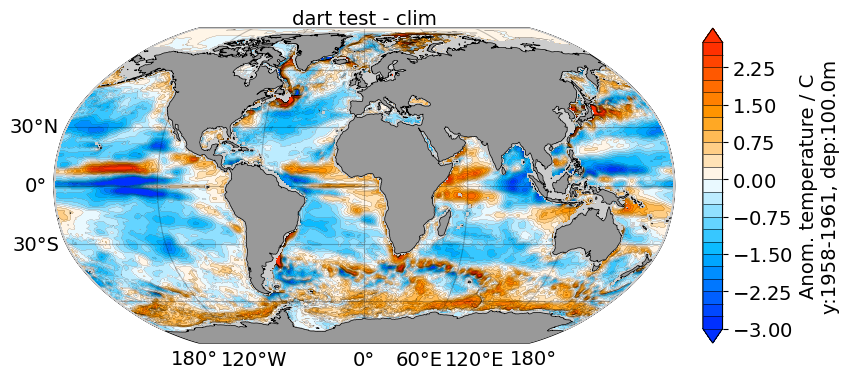

 --> elasped time to plot data: 0.34 min.


In [17]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
svname = list(data_list[0].data_vars)[0]
slabel = data_list[0][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_clim_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
    
#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi) 

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))

In [18]:
if do_papermill and do_parallel and client is not None: client.shutdown()